# Hippocampus

## Pattern separation

Define DG block

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

class DGModel(nn.Module):
    """
    Goal: separation
    Methods: sparsity
    """
    
    def __init__(self, input_size, output_size):
        super(DGModel, self).__init__()
        hidden_layer_size = input_size + output_size // 2
        # self.fc1 = nn.Linear(input_size, hidden_layer_size)
        # self.fc2 = nn.Linear(hidden_layer_size, output_size)
        self.fc1 = nn.Linear(input_size, output_size)
        
        # Weight initialization (Xavier)
        nn.init.xavier_uniform_(self.fc1.weight)
        # nn.init.xavier_uniform_(self.fc2.weight)
        self.k = 100  # Number of top activations to keep
        
    def forward(self, x):
        with torch.no_grad():  # Ensure no gradients are calculated for this model
            x = self.fc1(x)
            x = torch.tanh(x)  # Using tanh activation
            # x = self.fc2(x)
            # x = torch.relu(x)
            # Top-k sparsity: keep only top-k values, set others to zero
            mask = torch.zeros_like(x)
            _, topk_indices = torch.topk(x, self.k)
            mask.scatter_(0, topk_indices, 1)
            x = x * mask
        return x


We need some data to test these blocks

In [2]:
import math

w = 5
h = 5
sk = 5
w_s = w * sk
h_s = h * sk

# dg_model - Sparse encoding
N = w * h  # Input size
M = w_s * h_s   # Output size

# ec_to_ca3_model - Correcting encoding
H = N  # Input size
L = M   # Output size ?? M ??

# ca3_memory_model
T = M # or L # Input size
K = T # Output size = Input size

# ca1_model
input_size = N + K # the original input pattern + memory
hidden_size = math.floor(input_size * 0.7)  # Size of hidden layer
output_size = N  # Same as input size for reconstruction

# super simple ARC-like example
input_1 = torch.tensor([[[[0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0],
                          [0, 0, 1, 0, 0],
                          [0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0]]]], dtype=torch.float)

output_1 = torch.tensor([[[[0, 0, 1, 0, 0],
                           [0, 0, 1, 0, 0],
                           [1, 1, 1, 1, 1],
                           [0, 0, 1, 0, 0],
                           [0, 0, 1, 0, 0]]]], dtype=torch.float)

input_2 = torch.tensor([[[[0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 1]]]], dtype=torch.float)

output_2 = torch.tensor([[[[0, 0, 0, 0, 1],
                           [0, 0, 0, 0, 1],
                           [0, 0, 0, 0, 1],
                           [0, 0, 0, 0, 1],
                           [1, 1, 1, 1, 1]]]], dtype=torch.float)

We are going to work with 1D arrays. 

DG block creates a sparse representation of the input

In [3]:
dg_model = DGModel(N, M)

def forward_dg_model(dg_model, x):
    return dg_model(x.flatten())


In [4]:
x = input_1.flatten()
a = output_1.flatten()

y = forward_dg_model(dg_model, x)
print(y)
print(y.shape)

tensor([0.1983, -0.0000, -0.0000, 0.0000, -0.0000, -0.0000, 0.1660, 0.0000, -0.0000,
        0.0000, 0.0000, -0.0000, 0.2111, 0.1913, 0.0000, -0.0000, 0.0000, -0.0000,
        -0.0000, 0.0000, -0.0000, 0.0000, 0.0000, -0.0000, -0.0000, -0.0000, 0.0000,
        0.0000, 0.2507, 0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
        -0.0000, 0.0000, 0.0000, -0.0000, 0.1719, -0.0000, -0.0000, -0.0000, 0.0000,
        0.0000, 0.2284, 0.0000, 0.0000, 0.0000, 0.1908, 0.0000, 0.0000, -0.0000,
        0.0000, -0.0000, 0.2113, 0.0000, 0.1849, -0.0000, -0.0000, 0.0000, -0.0000,
        0.0000, 0.0000, -0.0000, 0.0000, 0.2168, 0.0000, 0.0000, 0.0000, 0.1752,
        -0.0000, 0.1875, -0.0000, 0.0000, -0.0000, 0.2089, 0.2293, 0.0000, 0.2500,
        0.0000, 0.0000, 0.0000, -0.0000, -0.0000, 0.2219, 0.1549, -0.0000, 0.0000,
        0.0000, 0.1529, -0.0000, -0.0000, -0.0000, 0.0000, -0.0000, -0.0000, -0.0000,
        -0.0000, -0.0000, -0.0000, 0.1851, -0.0000, 0.0000, 0.1885, 0.0000, -0

Before the sparse representation hits the memory
we need to add one independent network between the same input and the memory in parallel.
This will be used later as part of retrieval.
Its gould would be to help balance between sparse representation and real input and select important regions 
(that would help with ignoring noise (or with detecting invariants))

We add an Encoding model

In [5]:
class EncodingModel(nn.Module):
    """
    Goal: pattern retrieval
    Methods: compare sparse representation with the original
    """
    
    def __init__(self, input_size, output_size):
        super(EncodingModel, self).__init__()
        hidden_layer_size = output_size
        self.fc1 = nn.Linear(input_size, hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

In [6]:
ec_model = EncodingModel(H, L)
ec_optimizer = optim.AdamW(ec_model.parameters(), lr=0.0001)
ec_criterion = nn.MSELoss() # good for comparing pixel values

def forward_ec_to_ca3_model(ec_model, x):
    return ec_model(x)

def train_ec_to_ca3_model(ec_model, x, y):
    # Zero the parameter gradients
    ec_optimizer.zero_grad()

    # Compare reconstruction with the original input
    
    z = forward_ec_to_ca3_model(ec_model, x)
    loss = ec_criterion(z, y)

    # Backward pass: compute gradients
    loss.backward()

    # Optimization step: update weights
    ec_optimizer.step()

    print("Loss:", loss.item())
    # print("EC -> CA3 output:", z)
    
    return z, loss.item()


In [7]:
for i in range(500):
    print(i, "train_ec_to_ca3")
    z, loss = train_ec_to_ca3_model(ec_model, x, y)
    if loss < 0.000001:
        break

print(z)
print(z.shape)

0 train_ec_to_ca3
Loss: 0.011274606920778751
1 train_ec_to_ca3
Loss: 0.010643260553479195
2 train_ec_to_ca3
Loss: 0.010046098381280899
3 train_ec_to_ca3
Loss: 0.0094823706895113
4 train_ec_to_ca3
Loss: 0.008950436487793922
5 train_ec_to_ca3
Loss: 0.00844862312078476
6 train_ec_to_ca3
Loss: 0.007975568063557148
7 train_ec_to_ca3
Loss: 0.007529979571700096
8 train_ec_to_ca3
Loss: 0.007110448554158211
9 train_ec_to_ca3


Loss: 0.0067154779098927975
10 train_ec_to_ca3
Loss: 0.006343635264784098
11 train_ec_to_ca3
Loss: 0.005993564147502184
12 train_ec_to_ca3
Loss: 0.005663919262588024
13 train_ec_to_ca3
Loss: 0.005353350657969713
14 train_ec_to_ca3
Loss: 0.005060563795268536
15 train_ec_to_ca3
Loss: 0.004784394055604935
16 train_ec_to_ca3
Loss: 0.004523808602243662
17 train_ec_to_ca3
Loss: 0.004277863539755344
18 train_ec_to_ca3
Loss: 0.004045670386403799
19 train_ec_to_ca3
Loss: 0.003826397005468607
20 train_ec_to_ca3
Loss: 0.003619271796196699
21 train_ec_to_ca3
Loss: 0.0034235797356814146
22 train_ec_to_ca3
Loss: 0.0032386379316449165
23 train_ec_to_ca3
Loss: 0.0030637849122285843
24 train_ec_to_ca3
Loss: 0.0028983887750655413
25 train_ec_to_ca3
Loss: 0.0027418569661676884
26 train_ec_to_ca3
Loss: 0.002593639772385359
27 train_ec_to_ca3
Loss: 0.002453229622915387
28 train_ec_to_ca3
Loss: 0.00232015922665596
29 train_ec_to_ca3
Loss: 0.002193999942392111
30 train_ec_to_ca3
Loss: 0.0020743582863360643
3

## Memory

This is where patterns are stored. Associative memory is implemented by classic Hopfield networks (there are also Modern Hopfield Networks that pose as a generalization of Transformers, that is not what is used here :( )

In [8]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

class HopfieldNetworkTorch(nn.Module):
    def __init__(self, num_neurons):
        super(HopfieldNetworkTorch, self).__init__()
        self.num_neurons = num_neurons
        self.weights = torch.zeros(num_neurons, num_neurons)

    def store_patterns(self, patterns):
        """
        Store patterns into the weight matrix using Hebbian learning.
        Patterns should be a tensor of shape (num_patterns, num_neurons).
        """
        num_patterns = patterns.size(0)
        for i in range(num_patterns):
            p = patterns[i].unsqueeze(1)  # Make it a column vector
            self.weights += torch.mm(p, p.T)  # Hebbian learning rule
        # Ensure weights on the diagonal are zero
        self.weights.fill_diagonal_(0)
        self.weights /= num_patterns  # Normalize by the number of patterns
    
    def store_pattern(self, pattern):
        p = pattern.unsqueeze(1) # Make it a column vector
        self.weights += torch.mm(p, p.T) # Hebbian learning rule
        # Ensure weights on the diagonal are zero
        self.weights.fill_diagonal_(0)

    def forward(self, input_state, max_steps=100):
        """
        Forward pass: iteratively update the states of the network.
        Returns early if a stable state is reached.
        """
        with torch.no_grad():  # Ensure no gradients are calculated for this model
            state = input_state.clone()
            prev_state = state.clone()

            for i in range(max_steps):
                # Update all neurons at once for simplicity
                net_input = torch.matmul(self.weights, state)  # Weighted sum of inputs
                state = torch.tanh(net_input)  # Continuous activation (differentiable)
            
                # For each neuron, update its state
                # for i in range(self.num_neurons):
                #     net_input = torch.dot(self.weights[i], state)  # Weighted sum of inputs
                #     state[i] = 1 if net_input >= 0 else -1  # Update rule (sign function)

                # Early stopping if state does not change
                if torch.equal(state, prev_state):
                    break
                
                if i == max_steps - 1:
                    print(f'{max_steps} steps is not enough')
                prev_state = state.clone()

            return state
      
    def plot_weights(self):
        plt.figure(figsize=(6, 5))
        w_mat = plt.imshow(self.weights.detach().numpy(), cmap=cm.coolwarm)
        plt.colorbar(w_mat)
        plt.title("Network Weights")
        plt.tight_layout()
        plt.show()

torch.Size([1250])


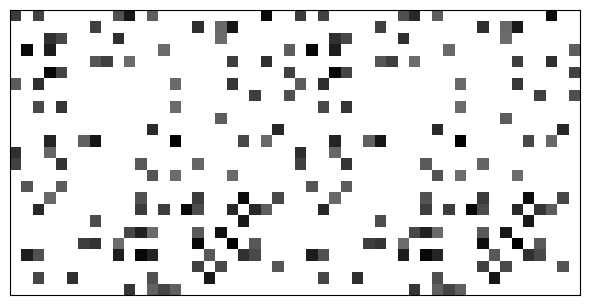

tensor([ 1.9825e-01, -0.0000e+00, -0.0000e+00,  ..., -3.8277e-07,
         1.5426e-05, -6.8434e-06], grad_fn=<CatBackward0>)

In [9]:
# Plot the figure
plt.figure(figsize=(6, 4))
yz = torch.cat([y, z])
print(yz.shape)
plt.imshow(yz.detach().view(2*w_s, h_s).T, cmap=plt.cm.gray_r)
plt.xticks([])  # No ticks on x axis
plt.yticks([])  # No ticks on y axis
plt.tight_layout()
plt.grid(False)
plt.show()
yz

In [10]:

hopfield_model = HopfieldNetworkTorch(T)

def forward_ca3_memory_model(hopfield_model, pp):
    u = hopfield_model(pp)
    return u

def train_ca3_memory_model(hopfield_model, y, z):
    # ca3_input = torch.cat([y, z]).clone().detach()
    for i in range(5):
        hopfield_model.store_pattern(z)
    # hopfield_model.store_patterns(torch.stack([y, y, y, y]))
    u = forward_ca3_memory_model(hopfield_model, z)
    return u


In [11]:
u = train_ca3_memory_model(hopfield_model, y, z)

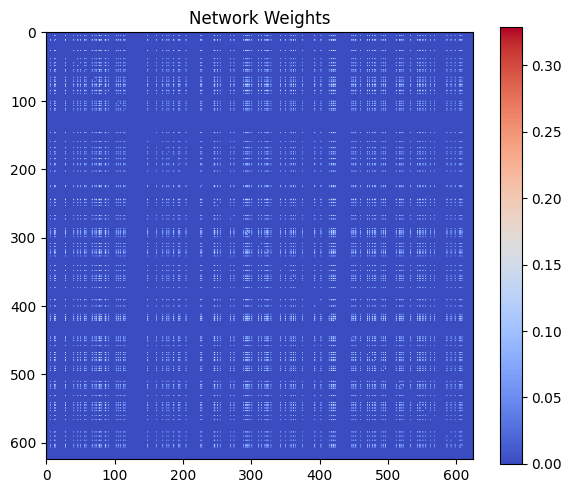

In [12]:
hopfield_model.plot_weights()

In [13]:
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, h, d_model, d_context, d_output):
        super(Attention, self).__init__()
        self.h = h
        self.d_k = d_model // h
        self.d_v = d_context
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out_linear = nn.Linear(d_model, d_output)

    def forward(self, z):
        if len(z.shape) == 1:
            batch_size = 1
        else:
            batch_size = z.shape[0]
        
        zz = z.view(batch_size, self.d_k)
        q = zz[:, :]
        k = zz[:, :]
        v = zz[:, :]
        
        query = self.q_linear(q)
        key = self.k_linear(k)
        value = self.v_linear(v)
        
        key_t = key.transpose(-2, -1)
        scores = torch.matmul(query, key_t) / math.sqrt(self.d_k)
        for x in range(self.d_v):
            for y in range(self.d_v):
                if y < x:
                    scores[:, x, y] = torch.zeros((batch_size))
                    
        p_attn = F.softmax(scores, dim=-1)

        x = torch.matmul(p_attn, value)

        x = self.out_linear(x)
        x = torch.sum(x, 1)
        return x

### Visualization

This is what is really stored in memory. Trying to grasp what kind of transformation happens in these three networks.

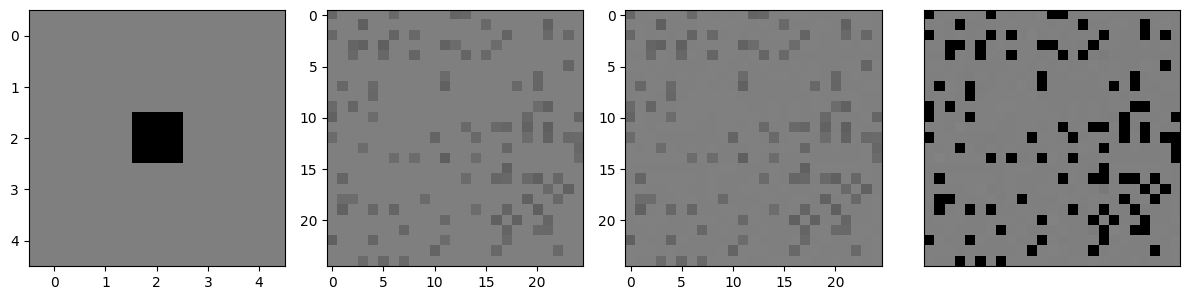

In [14]:
cmap = plt.cm.gray
norm = plt.Normalize(vmin=-1, vmax=1)

fig, axs = plt.subplots(1, 4, figsize=(12, 4))
axs[0].imshow(x.view(w,h), cmap=plt.cm.gray_r, norm=norm)
axs[1].imshow(y.view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
axs[2].imshow(z.detach().view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
axs[3].imshow(u.view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)


# Plot the figure
#plt.figure(figsize=(6, 4))
#plt.imshow(x, cmap=plt.cm.gray_r, norm=norm)
plt.xticks([])  # No ticks on x axis
plt.yticks([])  # No ticks on y axis
plt.tight_layout()
plt.grid(False)
plt.show()

## Mapping and reconstruction

This is the last block that is mainly used for retrieval.  

In [15]:
class MappingModel(nn.Module):
    """
    Goal: pattern mapping
    Methods: compare what stored in memory with the original
    """
    
    def __init__(self, input_size, hidden_size, output_size):
        super(MappingModel, self).__init__()
        
        # Layers for mapping and reconstruction
        self.fc_map = nn.Linear(input_size, hidden_size)  # Map Hopfield output to hidden representation
        self.fc_reconstruct = nn.Linear(hidden_size, output_size)  # Reconstruct to original size

    def forward(self, x):
        """
        Forward pass compares stored Hopfield output with the original input
        """
        # Map the Hopfield output to a hidden representation
        mapping = self.fc_map(x)
        hidden_repr = torch.relu(mapping)
        reconstructed_input = self.fc_reconstruct(hidden_repr)
        return reconstructed_input

In [16]:

# Instantiate the model
ca1_model = MappingModel(input_size, hidden_size, output_size)

# Define optimizer (e.g., Adam)
ca1_optimizer = optim.Adam(ca1_model.parameters(), lr=0.0001)

ca1_criterion = nn.MSELoss() # good for comparing pixel values

def forward_ca1_model(ca1_model, u, x):
    ca1_input = torch.cat([u, x]) # u -> K, x -> N
    # Compare reconstruction with the original input
    v = ca1_model(ca1_input)
    return v
    
def train_ca1_model(ca1_model, u, x, a):
    # Zero the parameter gradients
    ca1_optimizer.zero_grad()

    v = forward_ca1_model(ca1_model, u, x)
    loss = ca1_criterion(v, a)

    # Backward pass: compute gradients
    loss.backward()

    # Optimization step: update weights
    ca1_optimizer.step()

    print("Loss:", loss.item())
    print("Reconstructed Input:", v)
    
    return v

Loss: 0.3639127314090729
Reconstructed Input: tensor([-0.0536, -0.1150,  0.0025,  0.0061,  0.0157, -0.0156,  0.0509, -0.1391,
         0.0756, -0.0442,  0.0504, -0.0161, -0.0046,  0.0553,  0.0257,  0.0838,
         0.0633,  0.0777, -0.0704,  0.0254, -0.0599, -0.1026, -0.0452, -0.0740,
         0.1172], grad_fn=<AddBackward0>)
Loss: 0.3479338586330414
Reconstructed Input: tensor([-0.0479, -0.1066,  0.0265, -0.0072,  0.0091, -0.0091,  0.0410, -0.1152,
         0.0655, -0.0335,  0.0736,  0.0093,  0.0152,  0.0718,  0.0528,  0.0834,
         0.0599,  0.0916, -0.0747,  0.0247, -0.0516, -0.1021, -0.0216, -0.0729,
         0.1177], grad_fn=<AddBackward0>)
Loss: 0.3326994776725769
Reconstructed Input: tensor([-0.0413, -0.0985,  0.0493, -0.0158,  0.0022, -0.0027,  0.0306, -0.0921,
         0.0559, -0.0228,  0.0976,  0.0345,  0.0339,  0.0890,  0.0795,  0.0836,
         0.0565,  0.1050, -0.0800,  0.0242, -0.0431, -0.1012,  0.0011, -0.0721,
         0.1190], grad_fn=<AddBackward0>)
Loss: 0.31798496

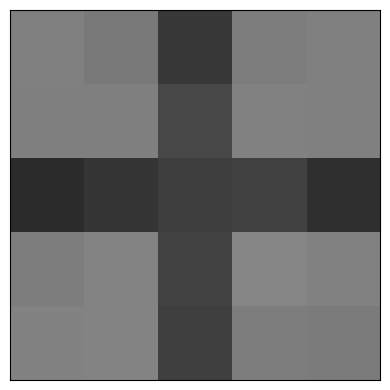

In [17]:
for i in range(30):
    v = train_ca1_model(ca1_model, u, x, a)


# Plot the figure
plt.figure(figsize=(6, 4))
plt.imshow(v.view(w,h).detach(), cmap=plt.cm.gray_r, norm=norm)
plt.xticks([])  # No ticks on x axis
plt.yticks([])  # No ticks on y axis
plt.tight_layout()
plt.grid(False)
plt.show()

In [18]:
# Another step
# v = train_ca1_model(ca1_model, u, x, a)

# plt.figure(figsize=(6, 4))
# plt.imshow(v.view(5,5).detach(), cmap=plt.cm.gray_r, norm=norm)
# plt.xticks([])  # No ticks on x axis
# plt.yticks([])  # No ticks on y axis
# plt.tight_layout()
# plt.grid(False)
# plt.show()

In [19]:

x = input_2.flatten()
a = output_2.flatten()

y = forward_dg_model(dg_model, x)
z, _ = train_ec_to_ca3_model(ec_model, x, y)
u = train_ca3_memory_model(hopfield_model, y, z)
v = train_ca1_model(ca1_model, u, x, a)


Loss: 0.007639314979314804
Loss: 0.48714566230773926
Reconstructed Input: tensor([-0.1927, -0.0376,  0.5223,  0.0024,  0.0719, -0.0295, -0.4149,  0.3615,
        -0.0097, -0.1041,  0.7910,  0.6021,  0.6028,  0.4556,  0.6454, -0.3591,
         0.2348,  0.3496, -0.4285, -0.2624, -0.2075, -0.0376,  0.6464, -0.3774,
        -0.0759], grad_fn=<AddBackward0>)


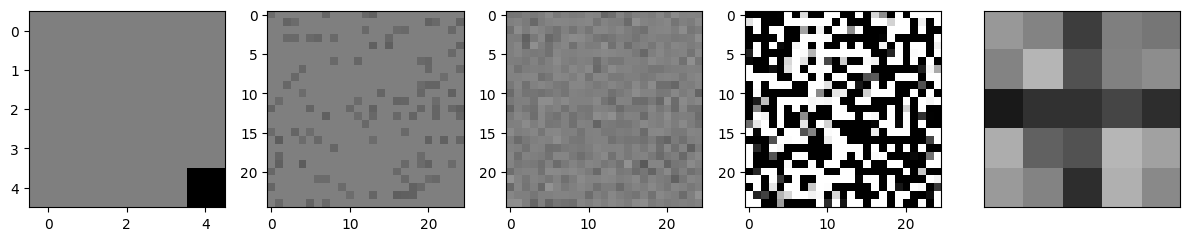

In [20]:
fig, axs = plt.subplots(1, 5, figsize=(12, 4))
axs[0].imshow(x.view(w,h), cmap=plt.cm.gray_r, norm=norm)
axs[1].imshow(y.view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
axs[2].imshow(z.detach().view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
axs[3].imshow(u.view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
axs[4].imshow(v.view(w,h).detach(), cmap=plt.cm.gray_r, norm=norm)

plt.xticks([])  # No ticks on x axis
plt.yticks([])  # No ticks on y axis
plt.tight_layout()
plt.grid(False)
plt.show()

Loss: 0.44091105461120605
Reconstructed Input: tensor([-0.1626, -0.0457,  0.5284, -0.0012,  0.1209, -0.0379, -0.3752,  0.3408,
         0.0159, -0.0511,  0.7528,  0.5970,  0.5696,  0.4432,  0.7016, -0.3443,
         0.2194,  0.3208, -0.3911, -0.1937, -0.1420,  0.0083,  0.6576, -0.2995,
        -0.0511], grad_fn=<AddBackward0>)
Loss: 0.3819245398044586
Reconstructed Input: tensor([-0.1209, -0.0542,  0.5240, -0.0010,  0.1863, -0.0485, -0.3240,  0.3085,
         0.0463,  0.0185,  0.6932,  0.5807,  0.5162,  0.4230,  0.7666, -0.3267,
         0.1990,  0.2799, -0.3425, -0.0999, -0.0543,  0.0671,  0.6682, -0.1986,
        -0.0139], grad_fn=<AddBackward0>)
Loss: 0.3194092810153961
Reconstructed Input: tensor([-0.0764, -0.0646,  0.5086,  0.0053,  0.2629, -0.0549, -0.2698,  0.2633,
         0.0780,  0.1021,  0.6243,  0.5586,  0.4527,  0.3916,  0.8304, -0.3084,
         0.1707,  0.2314, -0.2787,  0.0067,  0.0419,  0.1325,  0.6768, -0.0866,
         0.0360], grad_fn=<AddBackward0>)
Loss: 0.2589892

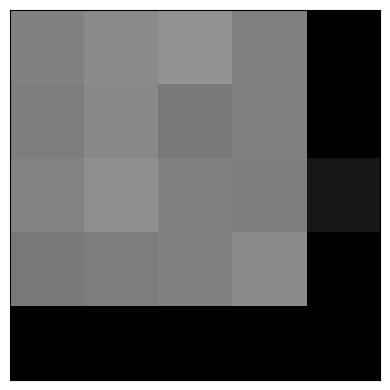

In [21]:
# Another step
for i in range(30):
    v = train_ca1_model(ca1_model, u, x, a)


plt.figure(figsize=(6, 4))
plt.imshow(v.view(5,5).detach(), cmap=plt.cm.gray_r, norm=norm)
plt.xticks([])  # No ticks on x axis
plt.yticks([])  # No ticks on y axis
plt.tight_layout()
plt.grid(False)
plt.show()

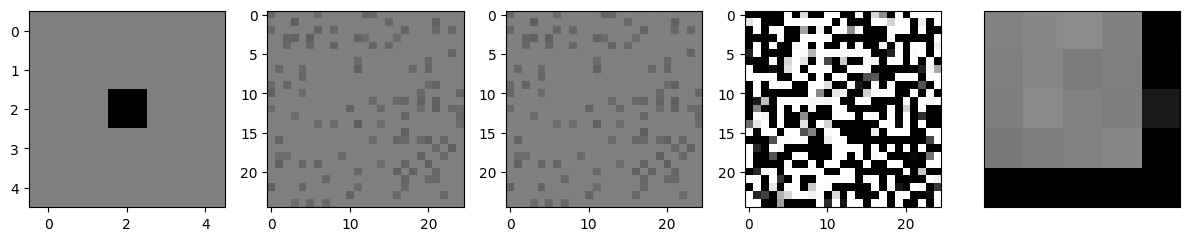

In [22]:

x = input_1.flatten()
a = output_1.flatten()

with torch.no_grad():
    y = forward_dg_model(dg_model, x)
    z = forward_ec_to_ca3_model(ec_model, x)
    u = forward_ca3_memory_model(hopfield_model, z)
    v = forward_ca1_model(ca1_model, u, x)

    fig, axs = plt.subplots(1, 5, figsize=(12, 4))
    axs[0].imshow(x.view(w,h), cmap=plt.cm.gray_r, norm=norm)
    axs[1].imshow(y.view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
    axs[2].imshow(z.detach().view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
    axs[3].imshow(u.view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
    axs[4].imshow(v.view(w,h).detach(), cmap=plt.cm.gray_r, norm=norm)

plt.xticks([])  # No ticks on x axis
plt.yticks([])  # No ticks on y axis
plt.tight_layout()
plt.grid(False)
plt.show()

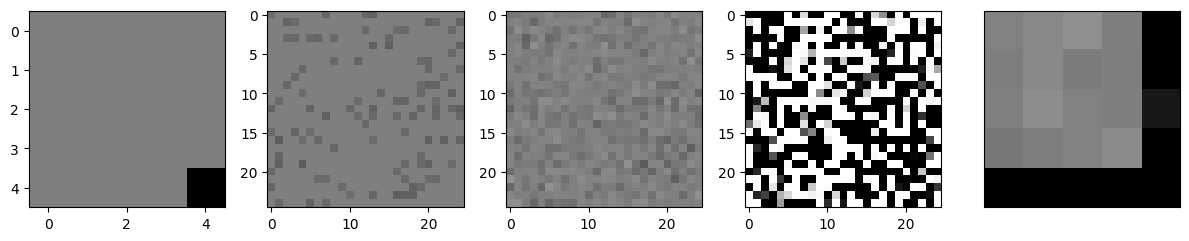

In [23]:
x = input_2.flatten()
a = output_2.flatten()

with torch.no_grad():
    y = forward_dg_model(dg_model, x)
    z = forward_ec_to_ca3_model(ec_model, x)
    u = forward_ca3_memory_model(hopfield_model, z)
    v = forward_ca1_model(ca1_model, u, x)

    fig, axs = plt.subplots(1, 5, figsize=(12, 4))
    axs[0].imshow(x.view(w,h), cmap=plt.cm.gray_r, norm=norm)
    axs[1].imshow(y.view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
    axs[2].imshow(z.detach().view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
    axs[3].imshow(u.view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
    axs[4].imshow(v.view(w,h).detach(), cmap=plt.cm.gray_r, norm=norm)

plt.xticks([])  # No ticks on x axis
plt.yticks([])  # No ticks on y axis
plt.tight_layout()
plt.grid(False)
plt.show()

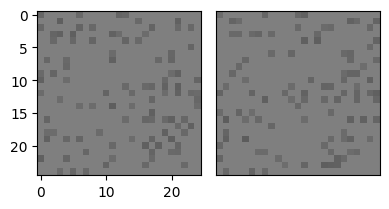

In [24]:

with torch.no_grad():
    x1 = input_1.flatten()
    a1 = output_1.flatten()

    y1 = forward_dg_model(dg_model, x1)
    z1 = forward_ec_to_ca3_model(ec_model, x1)
    u1 = forward_ca3_memory_model(hopfield_model, z1)

    x2 = input_2.flatten()
    a2 = output_2.flatten()

    y2 = forward_dg_model(dg_model, x2)
    z2 = forward_ec_to_ca3_model(ec_model, x2)
    u2 = forward_ca3_memory_model(hopfield_model, z2)


    fig, axs = plt.subplots(1, 2, figsize=(4, 4))
    axs[0].imshow(y1.view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
    axs[1].imshow(y2.view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)


plt.xticks([])  # No ticks on x axis
plt.yticks([])  # No ticks on y axis
plt.tight_layout()
plt.grid(False)
plt.show()